### Первая лаба - написать код для решения системы линейных уравнений методом Гаусса и методом Гаусса с выбором главного элемента.

In [28]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import sympy as smp
import scipy as sp

Система вида

$$
\begin{cases}
    a_{11}x_1+a_{12}x_2+\dots+a_{1n}x_n=b_1
    \\
    a_{21}x_1+a_{22}x_2+\dots+a_{2n}x_n=b_2
    \\
    \dots
    \\
    a_{n1}x_1+a_{n2}x_2+\dots+a_{nn}x_n=b_n
\end{cases}
$$

В матричном виде это уравнение

$$
A \cdot \vec{x} = \vec{b}
$$

Матрица этой системы

$$
A = 
\begin{bmatrix}
    a_{11} & a_{12} & \dots & a_{1n}
    \\
    a_{21} & a_{22} & \dots & a_{2n}
    \\
    \vdots & \vdots & \ddots & \vdots
    \\
    a_{n1} & a_{n2} & \dots & a_{nn}
\end{bmatrix}, \space \space
\vec{x} = 
\begin{bmatrix}
    x_1
    \\
    x_2
    \\
    \vdots
    \\
    x_n
\end{bmatrix}, \space \space
\vec{b} = 
\begin{bmatrix}
    b_1
    \\
    b_2
    \\
    \vdots
    \\
    b_n
\end{bmatrix} 
$$

Решение методом Гаусса предполагает приведение матрицы к треугольному виду

$$
\hat{A} = 
\begin{bmatrix}
    1 & c_{12} & c_{13} & \dots & c_{1n}
    \\
    0 & 1 & c_{23} & \dots & c_{2n}
    \\
    \vdots & \vdots & \ddots & \vdots
    \\
    0 & 0 & 0 & \dots & 1
\end{bmatrix}, \space \space
\hat{\vec{b}} = 
\begin{bmatrix}
    \hat{b_1}
    \\
    \hat{b_2}
    \\
    \vdots
    \\
    \hat{b_n}
\end{bmatrix} 
$$
$$

In [29]:
# Вывод текущей системы
def print_system(A, B, selected):
    result_string = '\n'
    for row in range(len(B)):
        start = ("/" if row==0 else "\\" if row==len(B)-1 else '|')
        end = ("\\" if row==0 else "/" if row==len(B)-1 else '|')
        result_string += start 
        for col in range(len(A[row])):
            result_string += "{1:7.3f}{0} ".format(" " if (selected is None or selected != (row, col)) else "*", A[row][col]) 
        result_string += end + f" * {start}  x{row+1}  {end} = {start}{B[row]:7.4f}  {end}" + '\n'
    return result_string


class LinearSolver:

    roots = None
    
    # Заполнение матрицы заданными числами
    def fill(self, A, B) -> None:
        self.A = np.array(A, copy=True, dtype=float)
        self.B = np.array(B, copy=True, dtype=float)

    # Рандомное заполнение матрицы
    def random_fill(self, n):
        self.A = np.random.random((n, n))
        self.B = np.random.random((n))
        # print(self.A.shape, self.B.shape)

    # Рандомное задание матрицы (с 0 на главной диагонали)
    def random_fill_with_zeros(self, n):
        self.A = np.random.random((n, n))
        self.B = np.random.random((n))
        for i in range(n):
            self.A[i, i] = 0

    # Перестановка строк
    def swap_rows(self, first_row, second_row) -> None:
        self.A[first_row], self.A[second_row] = self.A[second_row], np.copy(self.A[first_row])
        self.B[first_row], self.B[second_row] = self.B[second_row], np.copy(self.B[first_row])

    # Деление строки на число
    def divide_row(self, row, divider) -> None:
        self.A[row] = [a / divider if a != 0 else 0 for a in self.A[row]]
        self.B[row] /= divider

    # Совмещение строк
    def combine_rows(self, to_row, from_row, multiplier) -> None:
        self.A[to_row] = [(a + e * multiplier) for a, e in zip(self.A[to_row], self.A[from_row])]
        self.B[to_row] += self.B[from_row] * multiplier

    # Расчёт ошибки 
    def epsilon(self):
        x  = np.array(self.get_roots(), copy=True)
        x0 = np.linalg.solve(self.A, self.B)
        temp = np.abs(x - x0)
        res = 0
        for e in temp:
            res += e**2
        return np.sqrt(res)
    
    # Расчёт нормы невязки
    def delta(self):
        x  = np.array(self.get_roots(), copy=True)
        return np.linalg.norm(np.abs(self.A @ x - self.B))

    # Получение корней
    def get_roots(self):
        return self.roots
    
    # Число обусловленности системы
    def get_condence_number(self):
        return np.linalg.cond(self.A)

In [30]:
class Gauss(LinearSolver):
    def __init__(self, A=None, B=None):
        if A and B:
            super().__init__(A, B)
            self.roots = [0 for b in range(len(B))]
        else:
            self.A = None
            self.B = None

    # Решение системы методом Гаусса (обычным)
    # с выводом в файл этапов решения
    def solve_(self):
        with open('./src/solved_gauss_.txt', 'w', encoding='utf-8') as file:
            column = 0
            current_step = 0
            lines = []
            while(column < len(self.B)):
                current_step += 1
                line = f"\n{current_step}. "
                line += (f"Ищем ненулевой элемент в {column+1}-м столбце:")
                lines.append(line)
                current_row = None
                for r in range(column, len(self.A)):
                    if (self.A[r][column] != 0):
                        current_row = r
                        break

                if current_row is None:
                    line = ("\nРешений нет. :(")
                    lines.append(line)
                    return None
            
                line = print_system(self.A, self.B, (current_row, column))
                lines.append(line)

                if current_row != column:
                    current_step += 1
                    line = f"\n{current_step}. Переставляем строку с найденным элементом наверх:"
                    lines.append(line)

                    self.swap_rows(current_row, column)

                    line = print_system(self.A, self.B, (column, column))
                    lines.append(line)

                if self.A[column][column] != 1:
                    current_step += 1
                    line = f"\n{current_step}. Нормализуем строку:"
                    if abs(self.A[column][column]) > 1e-12:
                        self.divide_row(column, self.A[column][column])
                        lines.append(line)
                    else:
                        line += ('Мартица несовместна.\nРешений нет. :(')
                        lines.append(line)
                        file.writelines(lines)
                        return None
                    line = print_system(self.A, self.B, (column, column))
                    lines.append(line)

                current_step += 1
                line = (f"\n{current_step}. Обрабатываем строки ниже:")
                lines.append(line)

                for row in range(column+1, len(self.A)):
                    self.combine_rows(row, column, -self.A[row][column])

                line = print_system(self.A, self.B, (column, column))
                lines.append(line)

                column += 1
            
            current_step += 1
            line = (f"\n{current_step}. Матрица приведена к треугольному виду. Обратный ход.\n")
            lines.append(line)
            
            self.roots = [0 for b in self.B]
            for i in range(len(self.B)-1, -1, -1):
                self.roots[i] = self.B[i] - sum(x*a for x, a in zip(self.roots[i+1:], self.A[i][i+1:]))
        
            current_step += 1
            line = (f"\n{current_step}. Ответ:\n")
            line += ("\n".join(f"x{i+1} = {x:7.3f}" for i, x in enumerate(self.roots)))
            lines.append(line)
            
            file.writelines(lines)
        
        return None

    # Решение системы методом Гаусса (улучшенным)
    # с выводом в файл этапов решения
    def solve(self):
        with open('./src/solved_gauss.txt', 'w', encoding='utf-8') as file:
            column = 0
            current_step = 0
            lines = []
            while(column < len(self.B)):
                current_step += 1
                line = f"\n{current_step}. "
                line += (f"Ищем максимальный по модулю элемент в {column+1}-м столбце:")
                lines.append(line)
                current_row = None
                for r in range(column, len(self.A)):
                    if current_row is None or abs(self.A[r][column]) > abs(self.A[current_row][column]):
                        current_row = r

                if current_row is None:
                    line = ("\nРешений нет. :(")
                    lines.append(line)
                    return None
            
                line = print_system(self.A, self.B, (current_row, column))
                lines.append(line)

                if current_row != column:
                    current_step += 1
                    line = f"\n{current_step}. Переставляем строку с найденным элементом наверх:"
                    lines.append(line)

                    self.swap_rows(current_row, column)

                    line = print_system(self.A, self.B, (column, column))
                    lines.append(line)

                if self.A[column][column] != 1:
                    current_step += 1
                    line = f"\n{current_step}. Нормализуем строку:"
                    if abs(self.A[column][column]) > 1e-12:
                        self.divide_row(column, self.A[column][column])
                        lines.append(line)
                    else:
                        line += ('Мартица несовместна.\nРешений нет. :(')
                        lines.append(line)
                        file.writelines(lines)
                        return None
                    line = print_system(self.A, self.B, (column, column))
                    lines.append(line)

                current_step += 1
                line = (f"\n{current_step}. Обрабатываем строки ниже:")
                lines.append(line)

                for row in range(column+1, len(self.A)):
                    self.combine_rows(row, column, -self.A[row][column])

                line = print_system(self.A, self.B, (column, column))
                lines.append(line)

                column += 1
            
            current_step += 1
            line = (f"\n{current_step}. Матрица приведена к треугольному виду. Обратный ход.\n")
            lines.append(line)
            
            self.roots = [0 for b in self.B]
            for i in range(len(self.B)-1, -1, -1):
                self.roots[i] = self.B[i] - sum(x*a for x, a in zip(self.roots[i+1:], self.A[i][i+1:]))
        
            current_step += 1
            line = (f"\n{current_step}. Ответ:\n")
            line += ("\n".join(f"x{i+1} = {x:7.3f}" for i, x in enumerate(self.roots)))
            lines.append(line)
            
            file.writelines(lines)
        
        return None

    # Решение системы методом Гаусса (улучшенным)
    # без вывода в файл этапов решения
    def solve_without_steps(self):
        column = 0
        while(column < len(self.B)):
            current_row = None
            for r in range(column, len(self.A)):
                if current_row is None or abs(self.A[r][column]) > abs(self.A[current_row][column]):
                    current_row = r

            if current_row is None:
                return None
        
            if current_row != column:
                self.swap_rows(current_row, column)

            if A[column][column] != 1:
                if abs(self.A[column][column]) > 1e-12:
                    self.divide_row(column, self.A[column][column])
                else:
                    return None

            for row in range(column+1, len(self.A)):
                self.combine_rows(row, column, -self.A[row][column])
            column += 1
        
        self.roots = [0 for b in self.B]
        for i in range(len(self.B)-1, -1, -1):
            self.roots[i] = self.B[i] - sum(x*a for x, a in zip(self.roots[i+1:], self.A[i][i+1:]))
    
        return None


In [31]:
# Get a condence number of a matrix A without using numpy
def get_condence_number(A):
    max_row_sum = 0
    for row in A:
        max_row_sum = max(max_row_sum, sum(abs(x) for x in row))
    max_column_sum = 0
    for column in zip(*A):
        max_column_sum = max(max_column_sum, sum(abs(x) for x in column))
    return max_row_sum * max_column_sum

In [32]:
class MatrixOperator:
    def __init__(self, matrix):
        self.matrix = matrix

    def get_matrix(self):
        return self.matrix.copy()

    # Транспонирование матрицы
    def transpose(self):
        return list(zip(*self.matrix))
    
    # Получение минора матрицы
    def get_minor(self, i, j):
        return [row[:j] + row[j+1:] for row in (self.matrix[:i]+self.matrix[i+1:])]
    
    # Получение определителя матрицы
    def get_deternminant(self):
        if len(self.matrix) == 2:
            return self.matrix[0][0]*self.matrix[1][1] - self.matrix[0][1]*self.matrix[1][0]
        determinant = 0
        for c in range(len(self.matrix)):
            determinant += ((-1)**c)*self.matrix[0][c]*self.get_deternminant(self.get_minor(0, c))
        return determinant
    
    # Получение обратной матрицы
    def inverse(self):
        determinant = self.get_deternminant()
        if len(self.matrix) == 2:
            return [[self.matrix[1][1]/determinant, -1*self.matrix[0][1]/determinant],
                    [-1*self.matrix[1][0]/determinant, self.matrix[0][0]/determinant]]
        cofactors = []
        for r in range(len(self.matrix)):
            cofactorRow = []
            for c in range(len(self.matrix)):
                minor = self.get_minor(r, c)
                cofactorRow.append(((-1)**(r+c)) * self.get_deternminant(minor))
            cofactors.append(cofactorRow)
        cofactors = MatrixOperator(cofactors).transpose()
        for r in range(len(cofactors)):
            for c in range(len(cofactors)):
                cofactors[r][c] = cofactors[r][c]/determinant
        return cofactors

    # get condition number of a matrix A
    def get_condition_number(self):
        M = A.T @ A
        eigenvalues = np.linalg.eigvals(M)
        max_eigenvalue = max(eigenvalues)
        min_eigenvalue = min(eigenvalues)
        return np.sqrt(max_eigenvalue / min_eigenvalue)

In [181]:
def abc(A):
    return np.linalg.norm(A, ord=2) * np.linalg.norm(np.linalg.inv(A), ord=2)

In [169]:
class Seidel(LinearSolver):
    def __init__(self, A=None, B=None, eps=1e-6):
        if A and B:
            super().__init__(A.copy(), B.copy())
            self.roots = [0 for b in range(len(B))]
        self.eps = eps

    def random_fill(self, n):
        self.A = np.random.random((n, n))
        self.B = np.random.random((n))
        
        D = np.diag(np.diag(self.A))
        L = np.tril(self.A, -1)
        R = np.triu(self.A, 1)

        b = np.dot(np.linalg.inv(L + D), R)
        c = np.dot(np.linalg.inv(L + D), self.B)

        lambdas = np.linalg.eig(b)
        k = 0

        while any([np.abs(l) >= 1 for l in lambdas[0]]):
            self.A = np.random.random((n, n))
            self.B = np.random.random((n))
            
            k += 1
            D = np.diag(np.diag(self.A))
            L = np.tril(self.A, -1)
            R = np.triu(self.A, 1)

            b = np.dot(np.linalg.inv(L + D), R)
            c = np.dot(np.linalg.inv(L + D), self.B)

            lambdas = np.linalg.eig(b)

        # print(k)

    # Решение системы методом Зейделя
    def solve(self):
        n = len(self.B)

        x = np.zeros(n)
        x_new = np.zeros(n)

        D = np.diag(np.diag(self.A))
        L = np.tril(self.A, -1)
        R = np.triu(self.A, 1)

        b = np.dot(np.linalg.inv(L + D), R)
        c = np.dot(np.linalg.inv(L + D), self.B)

        self.k = 0
        lambdas = np.linalg.eig(b)

        if any([np.abs(l) >= 1 for l in lambdas[0]]):
            print('Невомзожно решить методом Зейделя: |λ| >= 1')
            return

        while True:
            self.k += 1
            x_new = -b @ x + c
            if np.linalg.norm(x_new - x) < self.eps:
                break
            x = x_new.copy()

        self.roots = x_new.copy()
        return None

    def solve_without_matrix_ops(self):
        n = len(self.B)
        
        x = np.zeros(n)
        x_new = np.zeros(n)
        self.k = 0 
        
        while True:
            self.k += 1
            for i in range(n):
                s1 = sum(self.A[i][j] * x_new[j] for j in range(i))
                s2 = sum(self.A[i][j] * x[j] for j in range(i + 1, n))
                x_new[i] = (self.B[i] - s1 - s2) / self.A[i][i]

            if max(abs(x_new[i] - x[i]) for i in range(n)) < self.eps:
                break
            x = x_new.copy()

        self.roots = x.copy()
        return None

    def get_iterations(self):
        return self.k

    def get_matrix_A(self):
        return self.A.copy()

    def get_matrix_B(self):
        return self.B.copy()

In [182]:
A = [
    [3, 3, -5],
    [1, 2, -1],
    [2, -1, 4]
]

B = [
    -1, 
    9,
    13
]

Исходная система:

/  3.000    3.000   -5.000  \ * /  x1  \ = /-1.0000  \
|  1.000    2.000   -1.000  | * |  x2  | = | 9.0000  |
\  2.000   -1.000    4.000  / * \  x3  / = \13.0000  /

Число обусловленности матрицы A: 7.1388841018326845
Число обусловленности матрицы A: 7.138884101832685
Число обусловленности матрицы A: 110


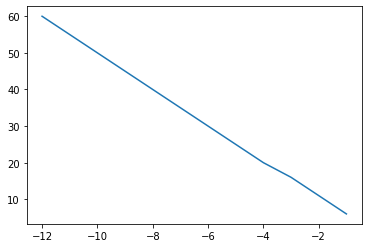

In [194]:
print("Исходная система:")
print(print_system(A.copy(), B.copy(), None))
print(f"Число обусловленности матрицы A: {np.linalg.cond(A.copy())}") 
print(f"Число обусловленности матрицы A: {abc(A.copy())}") 
print(f"Число обусловленности матрицы A: {get_condence_number(A.copy())}") 
SolverSeidel = Seidel(eps=1e-3)
SolverSeidel.random_fill(5)
A1 = SolverSeidel.get_matrix_A()
B1 = SolverSeidel.get_matrix_B()
# SolverSeidel.fill(A, B)
# SolverSeidel1 = Seidel(eps=1e-6)
# SolverSeidel1.fill(A1.copy(), B1.copy())
# SolverSeidel2 = Seidel(eps=1e-9)
# SolverSeidel2.fill(A1.copy(), B1.copy())
# SolverSeidel3 = Seidel(eps=1e-12)
# SolverSeidel3.fill(A1.copy(), B1.copy())
# SolverSeidel.random_fill(5)
# A1 = SolverSeidel.get_matrix_A()
# B1 = SolverSeidel.get_matrix_B()
# print(f"Число обусловленности матрицы A: {np.linalg.cond(A1.copy())}") 
# print(print_system(A1.copy(), B1.copy(), None))
# SolverSeidel.solve_without_matrix_ops()
# print(SolverSeidel.get_iterations())

# SolverSeidel1.solve_without_matrix_ops()
# print(SolverSeidel1.get_iterations())

# SolverSeidel2.solve_without_matrix_ops()
# print(SolverSeidel2.get_iterations())

# SolverSeidel3.solve_without_matrix_ops()
# print(SolverSeidel3.get_iterations())

iters = []
epsilons = [10**(-i) for i in range(1, 13)]

for i in range(len(epsilons)):

    SolverSeidel_i = Seidel(eps=epsilons[i])
    SolverSeidel_i.fill(A1.copy(), B1.copy())
    SolverSeidel_i.solve_without_matrix_ops()
    iters.append(SolverSeidel_i.get_iterations())

plt.plot(np.log10(epsilons), iters)

# X = SolverSeidel.get_roots()
# if X is None:
#     print('Решений нет. :(')
# else:
#     print(f'Roots: \t{X}')
#     print(f'Error: \t{SolverSeidel.epsilon()}')
#     print(f'Delta: \t{SolverSeidel.delta()}')

In [151]:
# print("Исходная система:")
# print(print_system(A.copy(), B.copy(), None))
# print(f"Число обусловленности матрицы A: {np.linalg.cond(A.copy())}") 
# print(f"Число обусловленности матрицы A: {abc(A.copy())}") 

SolverSeidel__ = Seidel(eps=1e-9)
n = 10
A = np.random.random((n, n))
B = np.random.random((n))
SolverSeidel__.fill(A, B)
# SolverSeidel__.random_fill(5)
A1_ = SolverSeidel__.get_matrix_A()
B1_ = SolverSeidel__.get_matrix_B()
print(f"Число обусловленности матрицы A: {np.linalg.cond(A1_.copy())}") 
print(print_system(A1_.copy(), B1_.copy(), None))
SolverSeidel__.solve()


X__ = SolverSeidel__.get_roots()
if X__ is None:
    print('Решений нет. :(')
else:
    print(f'Roots: \t{X__}')
    print(f'Error: \t{SolverSeidel__.epsilon()}')
    print(f'Delta: \t{SolverSeidel__.delta()}')

Число обусловленности матрицы A: 53.22843186434498

/  0.936    0.919    0.688    0.981    0.646    0.918    0.367    0.723    0.009    0.871  \ * /  x1  \ = / 0.2256  \
|  0.032    0.442    0.862    0.477    0.181    0.156    0.993    0.677    0.107    0.708  | * |  x2  | = | 0.0374  |
|  0.564    0.606    0.631    0.014    0.613    0.732    0.719    0.824    0.742    0.363  | * |  x3  | = | 0.6795  |
|  0.081    0.154    0.787    0.034    0.137    0.469    0.903    0.021    0.567    0.179  | * |  x4  | = | 0.6805  |
|  0.215    0.256    0.307    0.718    0.361    0.660    0.346    0.838    0.672    0.042  | * |  x5  | = | 0.4157  |
|  0.543    0.577    0.257    0.732    0.154    0.951    0.161    0.418    0.589    0.776  | * |  x6  | = | 0.2388  |
|  0.393    0.714    0.063    0.280    0.624    0.999    0.632    0.360    0.404    0.100  | * |  x7  | = | 0.1726  |
|  0.118    0.258    0.242    0.865    0.552    0.022    0.772    0.362    0.767    0.113  | * |  x8  | = | 0.4825  |
|  0

In [37]:
print(f"Число обусловленности матрицы A: {get_condence_number(A)}") 

SolverSeidel_ = Seidel(eps=1e-9)
SolverSeidel_.fill(A, B)
SolverSeidel_.solve_without_matrix_ops()

X = SolverSeidel_.get_roots()
if X is None:
    print('Решений нет. :(')
else:
    print(f'Roots: \t{X}')
    print(f'Error: \t{SolverSeidel_.epsilon()}')
    print(f'Delta: \t{SolverSeidel_.delta()}')

Число обусловленности матрицы A: 110
Roots: 	[0.75       6.35714286 4.46428571]
Error: 	5.69299766121973e-10
Delta: 	2.6870173489455475e-09
